In [1]:
!pip install datasets
!pip install textdistance
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 4.4 MB/s 
     |████████████████████████████████| 132 kB 73.4 MB/s 
     |████████████████████████████████| 212 kB 68.1 MB/s 
     |████████████████████████████████| 182 kB 52.1 MB/s 
     |████████████████████████████████| 127 kB 60.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.6 MB/s 
     |████████████████████████████████| 5.8 MB 29.7 MB/s 
     |████████████████████████████████| 1.3 MB 68.0 MB/s 
     |████████████████████████████████| 7.6 MB 66.3 MB/s 
  Created wheel for sente

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import textdistance
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
train_dataset = load_dataset('stsb_multi_mt', name='en', split='train')
test_dataset = load_dataset('stsb_multi_mt', name='en', split='test')

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


In [4]:
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)
train_df

,sentence1,sentence2,similarity_score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25
...,...,...,...
5744,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia,0.00
5745,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...,0.00
5746,President heading to Bahrain,President Xi: China to continue help to fight ...,0.00
5747,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders,0.00


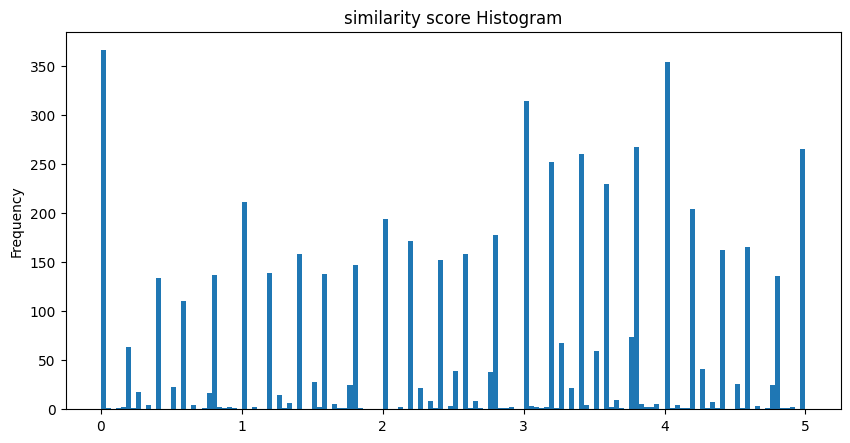

In [5]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})
plt.hist(train_df.similarity_score, bins=140)
plt.gca().set(title='similarity score Histogram', ylabel='Frequency')
plt.show()

In [6]:
nlp = spacy.load('en_core_web_sm')
def text_processing(sentence):
    """
    Lemmatize, lowercase, remove numbers and stop words
    
    Args:
      sentence: The sentence we want to process.
    
    Returns:
      A list of processed words
    """
    sentence = [token.lemma_.lower()
                for token in nlp(sentence) 
                if token.is_alpha and not token.is_stop]
    
    return sentence


In [7]:
train_df['clean_sentence1'] = train_df.sentence1.apply(text_processing)
train_df['clean_sentence2'] = train_df.sentence2.apply(text_processing)
test_df['clean_sentence1'] = test_df.sentence1.apply(text_processing)
test_df['clean_sentence2'] = test_df.sentence2.apply(text_processing)
train_df

,sentence1,sentence2,similarity_score,clean_sentence1,clean_sentence2
0,A plane is taking off.,An air plane is taking off.,5.00,"[plane, take]","[air, plane, take]"
1,A man is playing a large flute.,A man is playing a flute.,3.80,"[man, play, large, flute]","[man, play, flute]"
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80,"[man, spread, shreded, cheese, pizza]","[man, spread, shredded, cheese, uncooked, pizza]"
3,Three men are playing chess.,Two men are playing chess.,2.60,"[man, play, chess]","[man, play, chess]"
4,A man is playing the cello.,A man seated is playing the cello.,4.25,"[man, play, cello]","[man, seat, play, cello]"
...,...,...,...,...,...
5744,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia,0.00,"[severe, gales, storm, clodagh, hit, britain]","[merkel, pledge, nato, solidarity, latvia]"
5745,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...,0.00,"[dozen, egyptians, hostage, take, libyan, terr...","[egyptian, boat, crash, death, toll, rise, bod..."
5746,President heading to Bahrain,President Xi: China to continue help to fight ...,0.00,"[president, head, bahrain]","[president, xi, china, continue, help, fight, ..."
5747,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders,0.00,"[china, india, vow, bilateral, tie]","[china, scrambles, reassure, jittery, stock, t..."


In [10]:
def jaccard_sim(row):
    s1 = row['clean_sentence1']
    s2 = row['clean_sentence2']

    return textdistance.jaccard.normalized_similarity(s1, s2)

In [11]:
train_df['jaccard_sim'] = train_df.apply(jaccard_sim, axis=1)
test_df['jaccard_sim'] = test_df.apply(jaccard_sim, axis=1)

In [12]:
test_df.sort_values(by=['jaccard_sim'], ascending=False)[['sentence1', 'sentence2', 'similarity_score', 'jaccard_sim']].head(5)

,sentence1,sentence2,similarity_score,jaccard_sim
512,Three women cook.,Two women cooking.,3.2,1.0
759,How do you do that?,How should you do that?,4.0,1.0
60,The man is kissing and hugging the woman.,A man is hugging and kissing a woman.,5.0,1.0
727,You answered your own question.,You've answered your own question already.,5.0,1.0
737,Can you do this?,Can you do it?,5.0,1.0


In [13]:
test_df.sort_values(by=['jaccard_sim'], ascending=False)[['sentence1', 'sentence2', 'similarity_score', 'jaccard_sim']].tail(5)

,sentence1,sentence2,similarity_score,jaccard_sim
678,You need to read a lot to know what you like a...,"Yes, you should create a portfolio site to sho...",0.0,0.0
675,There is no maximum.,There is no quarantine period.,0.0,0.0
72,A woman opens a window.,A man is crawling.,0.0,0.0
874,There are two possible causes for this:,There are two options for you -,1.0,0.0
126,Someone is drawing.,Someone is dancing.,0.3,0.0


In [14]:
def cos_sim(sentence1_emb, sentence2_emb):
    """
    Cosine similarity between two columns of sentence embeddings
    
    """
    cos_sim = cosine_similarity(sentence1_emb, sentence2_emb)
    return np.diag(cos_sim)

In [15]:
tfidf_model = TfidfVectorizer(lowercase=True, stop_words='english')
X_train = pd.concat([train_df.sentence1, train_df.sentence2]).unique()

tfidf_model.fit(X_train)

train_emb1 = tfidf_model.transform(train_df.sentence1)
train_emb2 = tfidf_model.transform(train_df.sentence2)
test_emb1 = tfidf_model.transform(test_df.sentence1)
test_emb2 = tfidf_model.transform(test_df.sentence2)

train_df['tfidf_sim'] = cos_sim(train_emb1,train_emb2)
test_df['tfidf_sim'] = cos_sim(test_emb1,test_emb2)

In [16]:
test_df.sort_values(by=['tfidf_sim'], ascending=False)[['sentence1', 'sentence2', 'similarity_score', 'tfidf_sim']].head(5)

,sentence1,sentence2,similarity_score,tfidf_sim
1324,On War Criminals and Heroes: The Whitewashing ...,On war criminals and heroes: The whitewashing ...,5.000,1.0
648,The rule - When in doubt throw it out!,"I always go by the rule ""When in doubt, throw ...",4.000,1.0
1070,"""I expect Japan to keep conducting interventio...","Junya Tanase, forex strategist at JP Morgan Ch...",4.733,1.0
33,A cat is eating some corn.,A cat is eating corn on the cob.,4.250,1.0
60,The man is kissing and hugging the woman.,A man is hugging and kissing a woman.,5.000,1.0


In [17]:
test_df.sort_values(by=['tfidf_sim'], ascending=False)[['sentence1', 'sentence2', 'similarity_score', 'tfidf_sim']].tail(5)

,sentence1,sentence2,similarity_score,tfidf_sim
546,A woman is posing for a Christmas card.,A girl is taking a photo.,1.20,0.0
97,Someone typed on a keyboard.,Someone is typing.,4.50,0.0
95,The lady peeled the potatoe.,A woman is peeling a potato.,4.75,0.0
323,Two black and white dogs at the bottom of stairs.,A dog is lying at the bottom of a staircase ne...,2.60,0.0
242,A man is doing exercise.,A baby is laughing.,0.00,0.0


In [18]:
transformer_model = SentenceTransformer('stsb-mpnet-base-v2')

train_emb1 = transformer_model.encode(train_df.sentence1, show_progress_bar=True)
train_emb2 = transformer_model.encode(train_df.sentence2, show_progress_bar=True)
test_emb1 = transformer_model.encode(test_df.sentence1, show_progress_bar=True)
test_emb2 = transformer_model.encode(test_df.sentence2, show_progress_bar=True)

train_df['nn_sim'] = cos_sim(train_emb1, train_emb2)
test_df['nn_sim'] = cos_sim(test_emb1, test_emb2)

Downloading:   0%|          | 0.00/868 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/588 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Batches:   0%|          | 0/180 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

In [23]:
test_df.sort_values(by=['nn_sim'], ascending=False)[['sentence1', 'sentence2', 'similarity_score', 'nn_sim']].head(5)

,sentence1,sentence2,similarity_score,nn_sim
805,What are your goals?,What are you goals?,5.0,0.992782
623,A brown dog is jumping.,A brown dog is jumping,5.0,0.992404
566,People gathered in a room.,People gathered together in a room.,5.0,0.991575
427,a dog jumps into the water.,A dog is jumping into the water.,5.0,0.990334
136,A woman plays the flute.,A woman is playing the flute.,5.0,0.990013


In [20]:
test_df.sort_values(by=['nn_sim'], ascending=False)[['sentence1', 'sentence2', 'similarity_score', 'nn_sim']].tail(5)

,sentence1,sentence2,similarity_score,nn_sim
242,A man is doing exercise.,A baby is laughing.,0.0,-0.113115
156,A person is playing a piano.,A person is slicing a potato.,0.5,-0.113264
277,Two men standing in grass staring at a car.,A woman in a pink top posing with beer.,0.2,-0.132677
68,A man is playing a guitar.,A woman is riding a horse.,0.5,-0.148015
445,A brown and white dog is running across a brow...,A person hanging from a rocky cliff.,0.0,-0.211263


In [21]:
score_cols = ['similarity_score', 'jaccard_sim', 'tfidf_sim', 'nn_sim']

train_spearman_rank_corr = train_df[score_cols].corr(method='spearman').iloc[1:,0:1]*100
test_spearman_rank_corr = test_df[score_cols].corr(method='spearman').iloc[1:,0:1]*100

In [22]:
print(train_spearman_rank_corr)
print(test_spearman_rank_corr)

             similarity_score
jaccard_sim         66.409271
tfidf_sim           68.191136
nn_sim              96.558008
             similarity_score
jaccard_sim         66.026529
tfidf_sim           61.420989
nn_sim              88.572413
